In [2]:
# Step 0. Load libraries and custom modules
# Dataframes and matrices ----------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
plt.style.use('tableau-colorblind10')
# Mathematical functions -----------------------------------------------
from scipy.stats import norm
# Text processors ------------------------------------------------------
import unicodedata
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
# Preprocessing --------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Text modeling --------------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Model creating -------------------------------------------------------
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
# Metrics --------------------------------------------------------------
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
# Custom functions -----------------------------------------------------
from text_preprocessing import clean_stopwords 

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# We'll use a collection of sentiments for text analysis as a dataset
# This dataset was published in Saif M. Mohammad and Peter Turney. (2013), 
# ``Crowdsourcing a Word-Emotion Association Lexicon.'' 
# Computational Intelligence, 29(3): 436-465.
# It's only for research and educational purposes.
# URL: http://saifmohammad.com/WebPages/lexicons.html  
nrc = pd.read_csv('../data/raw/NRC.csv', names=['word','sentiment','polarity'])
nrc = nrc.query('polarity == 1')

In [7]:
nrc

,word,sentiment,polarity
19,abacus,trust,1
23,abandon,fear,1
25,abandon,negative,1
27,abandon,sadness,1
30,abandoned,anger,1
...,...,...,...
141461,zest,anticipation,1
141464,zest,joy,1
141466,zest,positive,1
141469,zest,trust,1


In [4]:
# Step 1. Load the data
# Data extracted from https://www.thetrumparchive.com
# Data case: During the 2016 US presidential election, the candidate 
# Donald Trump used twitter to communicate with potential voters. 
# The campaign was during 2015-06-17 and 2016-11-08
# We'll try to analyze these campaign tweets from iPhone and Android
# Data description
# source -> device of origin
# id_str -> unique identifier
# text -> tweet text content
# created_at -> Date of creation, not including timezone
# retweet_count -> Count of retweets (difusion)
# in_reply_to_usr_id_str -> If it's a reply, grab the user id
# favourite_count -> Count of users that liked the tweet
# is_retweet -> If the post is a retweet  
# 1.1 Open data and get a glimpse
df_raw = pd.read_csv('../data/raw/trump_tweets.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20761 entries, 0 to 20760
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   source                   20761 non-null  object 
 1   id_str                   20761 non-null  int64  
 2   text                     20761 non-null  object 
 3   created_at               20761 non-null  object 
 4   retweet_count            20761 non-null  int64  
 5   in_reply_to_user_id_str  2442 non-null   float64
 6   favorite_count           20761 non-null  int64  
 7   is_retweet               20761 non-null  bool   
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 1.1+ MB


In [5]:
# 1.1 Sample some observations
df_raw.sample(10)

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
12471,Twitter for iPhone,671330229596659712,"How is Chris Christie running the state of NJ,...",2015-11-30T14:09:34Z,3298,NaN,4655,False
13260,Twitter for Android,640133656393195520,"The Dallas event in two weeks, at the American...",2015-09-05T12:05:31Z,1579,NaN,1845,False
2881,Twitter Web Client,233915014099132416,All recent Presidents have released their tran...,2012-08-10T13:17:39Z,328,NaN,52,False
9104,Twitter Web Client,296715825891659776,Oh the wonders of the Arab Spring. Our new all...,2013-01-30T20:25:40Z,237,NaN,52,False
7885,Twitter Web Client,313735229430964227,Vattenfall CEO stated that the company needed ...,2013-03-18T19:34:42Z,17,NaN,4,False
8672,Twitter Web Client,302063403407650817,It is important to think positively. Negative ...,2013-02-14T14:35:02Z,1376,NaN,564,False
15223,Twitter for Android,803434300846862336,.@CNN is so embarrassed by their total (100%)...,2016-11-29T03:03:59Z,25140,NaN,91706,False
6430,Twitter Web Client,344822631507324930,@scottymcd1980 A round of golf compliments o...,2013-06-12T14:24:56Z,7,234946101.0,11,False
7755,Twitter Web Client,314771578850275329,Remember the golden rule of negotiating: He wh...,2013-03-21T16:12:47Z,715,NaN,325,False
5283,Twitter for Android,376482993353019392,@dexterpugh Great looking couple-good to hav...,2013-09-07T23:11:54Z,0,392081766.0,1,False


In [8]:
# Step 2. Transform and wrangle the data
# 2.1 Make a copy
df_interim = df_raw.copy()

In [9]:
# 2.2 Get rid of uninformative columns
df_interim = df_interim.drop(['id_str','is_retweet','in_reply_to_user_id_str'], axis=1)

In [10]:
# 2.3 Convert columns to the right format
df_interim['created_at'] = df_interim['created_at'].astype('datetime64')
df_interim['source'] = pd.Categorical(df_interim['source'])

In [11]:
# 2.4 Filter dates for analysis
df_interim = df_interim.loc[(df_interim['created_at'] >= '2015-06-17') \
    & (df_interim['created_at'] <= '2016-11-08')]

In [12]:
# 2.5 Consider time is UTC, convert to EST
#llevamos la hora a EST, 5 horas de dif
df_interim['created_at'] += pd.Timedelta(-5, unit='h') #le saco las 5 horas de diferencia


In [13]:
# 2.5 Filter source for analysis, solo analicamos si viene de iPhone o Android
df_interim = df_interim.loc[(df_interim['source'].str.contains('iPhone')) \
    | (df_interim['source'].str.contains('Android'))]
df_interim['source'] = df_interim['source'].cat.remove_unused_categories()

In [14]:
# 2.5 Save and create a copy for analysis
df_interim.to_csv('../data/interim/trump_tweets.csv', index=False)
df = df_interim.copy()

In [15]:
# Step 3. Perform EDA
# 3.1 Get basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3946 entries, 12072 to 18506
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   source          3946 non-null   category      
 1   text            3946 non-null   object        
 2   created_at      3946 non-null   datetime64[ns]
 3   retweet_count   3946 non-null   int64         
 4   favorite_count  3946 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(2), object(1)
memory usage: 158.0+ KB


In [16]:
# 3.2 Get a sample
df.sample(10)

,source,text,created_at,retweet_count,favorite_count
16609,Twitter for iPhone,I will be interviewed by @oreillyfactor tonigh...,2016-07-12 16:59:45,2847,11258
15378,Twitter for iPhone,"Wow! I hear you Warren, Michigan. Streaming li...",2016-10-31 15:49:56,8538,24427
17991,Twitter for iPhone,Thank you for your continued support!\n#MakeAm...,2016-02-15 16:16:00,3484,9873
13911,Twitter for Android,Mexico is killing the United States economical...,2015-06-19 20:54:25,1033,1770
18266,Twitter for iPhone,A wonderful story on Iowa voters by @arappepor...,2016-01-23 12:23:12,1113,2978
18071,Twitter for iPhone,You can find your polling locations at: \nhttp...,2016-02-09 10:20:59,1978,4927
13363,Twitter for Android,"@ABCPolitics must apologize. My statement ""we'...",2015-08-20 23:04:52,667,861
15374,Twitter for iPhone,JOIN ME TOMORROW IN FLORIDA!\n\nMIAMI•12pm\nht...,2016-11-01 08:35:47,8773,17583
17271,Twitter for iPhone,Thank you @DonaldJTrumpJr &amp; @EricTrump. #T...,2016-04-26 08:33:24,4200,10282
16651,Twitter for Android,Crooked Hillary Clinton lied to the FBI and to...,2016-07-06 07:31:27,10376,28329


In [17]:
# 3.3 Describe numerical and datetime data
df.describe(datetime_is_numeric=True)

,created_at,retweet_count,favorite_count
count,3946,3946.000000,3946.000000
mean,2016-03-31 07:49:53.323872256,5839.465281,15666.982767
min,2015-06-19 20:03:05,61.000000,167.000000
25%,2015-12-20 18:19:10.500000,2013.250000,5350.000000
50%,2016-03-16 05:29:30.500000,4162.500000,11981.500000
75%,2016-07-25 09:04:26.500000,7807.250000,21527.000000
max,2016-11-07 17:21:53,168765.000000,297281.000000
std,NaN,6156.818896,14650.408743


In [18]:
# 3.4 Describe categorical data
df['source'].value_counts()

Twitter for iPhone     2099
Twitter for Android    1847
Name: source, dtype: int64

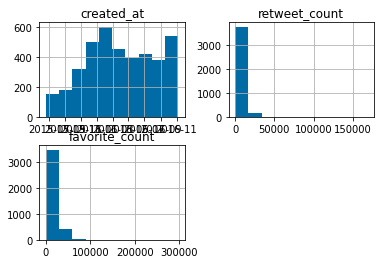

In [19]:
# 3.5 Get histograms for numerical data
df.hist()
plt.show()

#valores sesgados

In [20]:
# 3.6 Make a plot of tweets frequence rate by source
#vamos a detectar a que hora opera los twets, armo un pipeline de datos, son varias operaciones en un mismo ()
df_plot = (df
            .assign(hour=df['created_at'].dt.hour)
            .groupby(['source','hour'])
            .agg(count=('source','count'))
            .assign(rate=lambda df:df['count']/df.groupby('source')['count'].sum())
            .reset_index()
            )
df_plot

,source,hour,count,rate
0,Twitter for Android,0,22,0.011911
1,Twitter for Android,1,2,0.001083
2,Twitter for Android,2,6,0.003249
3,Twitter for Android,3,1,0.000541
4,Twitter for Android,4,28,0.015160
5,Twitter for Android,5,98,0.053059
6,Twitter for Android,6,159,0.086086
7,Twitter for Android,7,194,0.105035
8,Twitter for Android,8,210,0.113698
9,Twitter for Android,9,132,0.071467


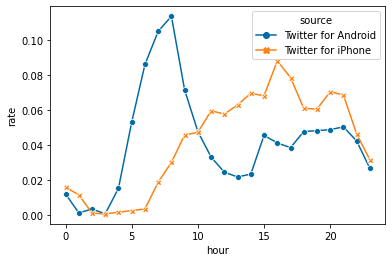

In [22]:
sns.lineplot(data=df_plot, x="hour", y="rate", hue="source", markers=True, style="source", dashes=False)
plt.show()

#se ve q hay dos personas con los celulares

In [24]:
# 3.7 Get a glimpse of the most retweeted tweets
df.sort_values(by='retweet_count', ascending=False)[['text','retweet_count']][:10] #veo las 10 primeras


,text,retweet_count
16875,How long did it take your staff of 823 people ...,168765
17183,Happy #CincoDeMayo! The best taco bowls are ma...,85465
15333,MAKE AMERICA GREAT AGAIN!,59098
15758,Here is my statement. https://t.co/WAZiGoQqMQ,51891
16548,Such a great honor to be the Republican Nomine...,41616
15340,If Obama worked as hard on straightening out o...,41479
15827,For those few people knocking me for tweeting ...,40850
15756,The media and establishment want me out of the...,40772
16583,I am pleased to announce that I have chosen Go...,38782
16848,Is President Obama going to finally mention th...,38456


In [26]:
# 3.8 Get a glimpse of the most liked tweets
df.sort_values(by='favorite_count', ascending=False)[['text','favorite_count']][:10] #veo las 10 primeras


,text,favorite_count
16875,How long did it take your staff of 823 people ...,297281
16548,Such a great honor to be the Republican Nomine...,129652
15758,Here is my statement. https://t.co/WAZiGoQqMQ,120244
15781,Mike Pence won big. We should all be proud of ...,120189
17183,Happy #CincoDeMayo! The best taco bowls are ma...,119759
15333,MAKE AMERICA GREAT AGAIN!,115387
15827,For those few people knocking me for tweeting ...,107497
15756,The media and establishment want me out of the...,105680
15340,If Obama worked as hard on straightening out o...,102045
16583,I am pleased to announce that I have chosen Go...,92250


In [28]:
# 3.9 Let's get a glimpse of common words in the tweets' text
df['text'].str.split(expand=True).stack().value_counts()[:10]

the    1965
to     1369
and    1186
I      1133
in     1098
a       987
of      957
is      904
on      829
for     703
dtype: int64

In [31]:
# 3.10 Process text to extract stopwords
df['text_clean'] = df.text.str.lower()
stop_dict = stopwords.words('english')
df['text_clean'] = df['text_clean'].apply(lambda x: clean_stopwords(x,stop_dict=stop_dict)) #uso lambda porq tengo q pasarle dos paramentros a la funcion, si fuera uno solo la puedo aplicar directo sin lambda
df['text_clean'] = df['text_clean'].str.replace(r'''['!,.]''','',regex=True)


In [32]:
# 3.11 Extract urls
url_pat = 'https://t.co/[A-Za-z\d]+|&amp;' #url q linkean a imagenes, esto no nos interesa
df['text_clean'] = df['text_clean'].str.replace(url_pat,'',regex=True)


In [ ]:
#def caracteres_no_alfanumericos(text):
#"""
#Sustituye caracteres raros, no digitos y letras
#Ej. hola 'pepito' como le va? -> hola pepito como le va
#"""
#return re.sub("(\\W)+"," ",text)

In [33]:
# 3.12 Extract special characters
#r'''[!.,():\-%$/'"']'''
df['text_clean'] = df['text_clean'].str.replace(r'''[!.,():\-%$/'"']''','',regex=True)

In [34]:
# 3.13 Extract numbers
df['text_clean'] = df['text_clean'].str.replace(r'[\d]+','',regex=True)

In [36]:
# 3.14 See the results
#df['text_clean']
df[['text','text_clean']].sample(10)

,text,text_clean
12325,"Our VISA system is broken, like so much else i...",visa system broken like much else country bett...
16343,CNN anchors are completely out of touch with e...,cnn anchors completely touch everyday people w...
16000,Will be in Missouri today with Melania for the...,missouri today melania funeral wonderful truly...
18217,Even though I beat him in the first six debate...,even though beat first six debates especially ...
12330,Great interview tonight @donlemon - very profe...,great interview tonight @donlemon professiona...
17162,Join me in Washington today!\nSpokane tickets:...,join washington today spokane tickets httpstco...
12660,I will be interviewed on @MariaBartiromo @FoxB...,interviewed @mariabartiromo @foxbusiness
12194,".@MissUniverse final 3 on now. Great people, g...",@missuniverse final now great people great ne...
16394,"General John Allen, who I never met but spoke ...",general john allen never met spoke last night ...
12238,Departing for #GOPDebate. Let's #MakeAmericaGr...,departing #gopdebate lets #makeamericagreataga...


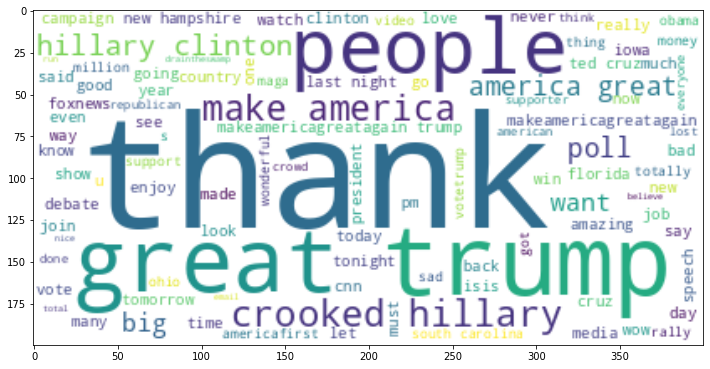

In [37]:
# 3.15 Let's see a wordcloud
#hacemos la nube de palabras

text= ' '.join(i for i in df.text_clean)
wordcloud = WordCloud(max_words=100, background_color='White').generate(text)
plt.figure(figsize=[12,12])
plt.imshow(wordcloud,interpolation='bilinear')
plt.show()

#el tamaño de la letra si es informativo

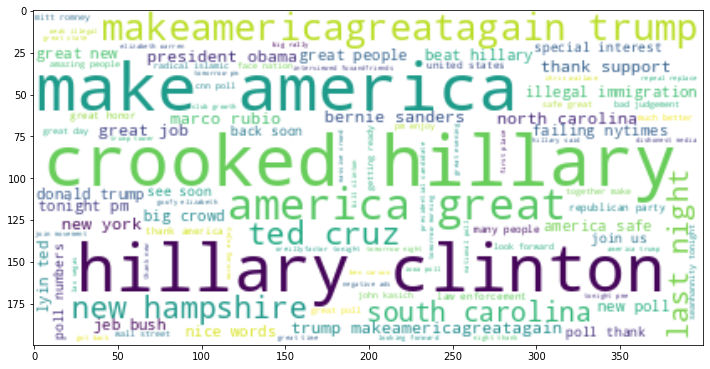

In [38]:
#construccion de dos palabras q se repiten una y otra vez . Bigramo - dos palabras q van juntas
#ahi vemos cuantas veces se repiten
#palabras secuenciadas de 2, hillary rufiana -> le decia Trump en sus tweets, muy mal educado

wordcloud_bg = WordCloud(collocation_threshold=2,collocations=True,max_words=100,background_color='White').generate(text)
plt.figure(figsize=[12,12])
plt.imshow(wordcloud_bg,interpolation='bilinear')
plt.show()

In [40]:
#con esto veo los sentimientos de la persona, se ve mucha regatividad !

df_word_split=(df
                .drop(['text','created_at','retweet_count','favorite_count'],axis=1)
                .assign(text=df['text_clean'].str.split())
                ).explode('text').drop('text_clean',axis=1).rename(columns={'text':'word'})
df_word_split              

,source,word
12072,Twitter for Android,would
12072,Twitter for Android,like
12072,Twitter for Android,wish
12072,Twitter for Android,everyone
12072,Twitter for Android,happy
...,...,...
18506,Twitter for Android,together
18506,Twitter for Android,make
18506,Twitter for Android,america
18506,Twitter for Android,great


In [41]:
#armamos un join
df_word_split.merge(nrc[['word','sentiment']],on='word',how='inner')

,source,word,sentiment
0,Twitter for Android,happy,anticipation
1,Twitter for Android,happy,joy
2,Twitter for Android,happy,positive
3,Twitter for Android,happy,trust
4,Twitter for iPhone,happy,anticipation
...,...,...,...
17547,Twitter for Android,stiff,negative
17548,Twitter for Android,embarrassment,fear
17549,Twitter for Android,embarrassment,negative
17550,Twitter for Android,embarrassment,sadness


In [46]:
#\ esto nos permite hacer multi linea sin hacer el pipe
df_sent = df_word_split.\
                merge(nrc[['word','sentiment']],on='word',how='inner').\
                groupby(['source','sentiment']).agg(count=('sentiment','count')).\
                reset_index().pivot_table(index=['sentiment'],columns=['source'],values='count').\
                reset_index().\
                rename(columns={"Twitter for Android":"Android","Twitter for iPhone":"iPhone"})


df_sent

source,sentiment,Android,iPhone
0,anger,949,514
1,anticipation,986,725
2,disgust,632,307
3,fear,815,477
4,joy,743,543
5,negative,1671,925
6,positive,1963,1522
7,sadness,911,512
8,surprise,587,385
9,trust,1363,1022


In [51]:
#odd ratios
#vamos a calcular el intervalo de confianza

#df_odd_ratio = df_sent.\
 #               assign(odd_ratio = (df_sent['Android']/(df_sent['Android']-sum()-df_sent['Android']))/(df_sent['iPhone']/(df_sent['iPhone']).sum()-df_sent['iPhone'])))

df_odd_ratio = df_sent.\
                assign(odd_ratio = (df_sent['Android']/(df_sent['Android'].sum()-df_sent['Android']))/(df_sent['iPhone']/(df_sent['iPhone'].sum()-df_sent['iPhone'])))

#logaritmo 
#Creamos columna con el logaritmo
df_odd_ratio['log_or'] = np.log(df_odd_ratio['odd_ratio'])

#los tweet del iphone son todos negativos, o sea lo q escribe Trump


In [52]:
df_odd_ratio.sort_values(by='log_or',ascending=False)

source,sentiment,Android,iPhone,odd_ratio,log_or
2,disgust,632,307,1.365482,0.311508
0,anger,949,514,1.225269,0.203160
5,negative,1671,925,1.212601,0.192767
7,sadness,911,512,1.176546,0.162583
3,fear,815,477,1.124833,0.117634
8,surprise,587,385,0.994922,-0.005091
4,joy,743,543,0.885109,-0.122044
1,anticipation,986,725,0.876222,-0.132136
9,trust,1363,1022,0.851456,-0.160808
6,positive,1963,1522,0.806001,-0.215670


In [ ]:
#vamos a crear intervalos de confianza
#error standar

df_odd_ratio['se'] = np.sqrp